In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from PIL import Image
from scipy import ndimage
import pandas as pd
import imageio

%matplotlib inline

In [3]:
# labels = np.genfromtxt('labels.csv', delimiter=',')
labels = pd.read_csv('labels.csv', float_precision='road_trip')
labels.head(5)

FileNotFoundError: [Errno 2] File b'labels.csv' does not exist: b'labels.csv'

In [14]:
labels["base color R"] = labels["base color R"].str[1:]
labels["base color B"] = labels["base color B"].str[:-1]
labels["specular color R"] = labels["specular color R"].str[1:]
labels["specular color B"] = labels["specular color B"].str[:-1]
labels["img_name"] = labels["img_name"].str[:-3]+"jpg"

In [15]:
labels.head(5)

,Unnamed: 0,img_name,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0,0.jpg,0.196696,0.02551167982996516,0.523569,0.09533690194549593,0.903675,0.9414576345001383,0.927580,0.418087362819755,0.120439,0.941755
1,1,1.jpg,0.563387,0.13560656102894886,0.715835,0.6311335628961977,0.381407,0.9228773407900674,0.328530,0.294482323738513,0.439152,0.511734
2,2,2.jpg,0.433630,0.06292513279208145,0.468129,0.49781547380782,0.622876,0.8260393377700712,0.115993,0.1549741111822439,0.646591,0.490058
3,3,3.jpg,0.471443,0.8909351516333082,0.133360,0.7187711144029106,0.419356,0.08579008506320773,0.466882,0.36951439970192435,0.154928,0.632136
4,4,4.jpg,0.172493,0.1089380911674539,0.179026,0.4079338804909298,0.893968,0.9620524644071147,0.906355,0.3523653506316685,0.708425,0.002353


In [16]:
vector_values = labels.iloc[:,2:]
vector_values = vector_values.astype(float)
vector_values.head(5)

,base,base color R,base color G,base color B,specular,specular color R,specular color G,specular color B,specular roughness,metalness
0,0.196696,0.025512,0.523569,0.095337,0.903675,0.941458,0.927580,0.418087,0.120439,0.941755
1,0.563387,0.135607,0.715835,0.631134,0.381407,0.922877,0.328530,0.294482,0.439152,0.511734
2,0.433630,0.062925,0.468129,0.497815,0.622876,0.826039,0.115993,0.154974,0.646591,0.490058
3,0.471443,0.890935,0.133360,0.718771,0.419356,0.085790,0.466882,0.369514,0.154928,0.632136
4,0.172493,0.108938,0.179026,0.407934,0.893968,0.962052,0.906355,0.352365,0.708425,0.002353


In [17]:
np_labels = vector_values.values
np_labels[0]

array([0.19669609, 0.02551168, 0.52356934, 0.0953369 , 0.90367509,
       0.94145763, 0.92757973, 0.41808736, 0.1204395 , 0.94175506])

THE BELOW CELL TAKES AGES TO RUN. ONLY RUN IT ONCE.

In [20]:
imagedir = './'
N = 100
filelist = ["images/" + str(i) + ".jpg" for i in range(N)]
images = np.array([np.array(imageio.imread(fname)) for fname in filelist])

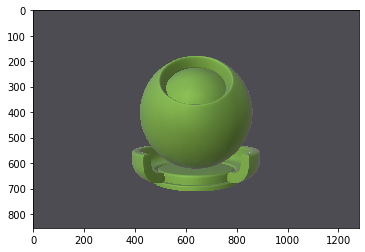

In [21]:
plt.imshow(images[99])

In [60]:
X_train_orig = images[0:int(0.9*N)]/255
X_test_orig = images[int(0.9*N):]/255
Y_train = np_labels[0:int(0.9*N)].T
Y_test = np_labels[int(0.9*N):].T

In [61]:
# Reshape inputs
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T

In [62]:
n_x = X_train.shape[0]
n_y = Y_train.shape[0]
n_y

10

In [63]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [64]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [10, 3283200]
                        b1 : [10, 1]
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W = tf.get_variable("W", [10, 3283200], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b = tf.get_variable("b", [10, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W": W,
                  "b": b}
    
    return parameters

In [65]:
# forward propagation
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z1 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W = parameters['W']
    b = parameters['b']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W, X), b)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.sigmoid(Z1)                                    # A1 = relu(Z1)
    ### END CODE HERE ###
    
    return Z1

In [66]:
# compute cost
def compute_cost(Z1, Y):
    """
    Computes the cost
    
    Arguments:
    Z1 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z1
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z1)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [69]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 10, minibatch_size = 5, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z1 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z1, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z1), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [ ]:
parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1555.196282
Cost after epoch 1: 633.403002
Cost after epoch 2: 445.845156
